For this project, I am trying to predict adverse drug reactions (ADRs) using features based on proteins the drugs interact with.  An ADR prediction model might be useful for drug developers to determine whether a new drug they developed is likely to cause certain side effects.  By examining the feature importances of the model, we may also be able to uncover new proteins or pathways that are associated with the ADRs, which could help in the early stages of drug development.

In this notebook, I will gather and process the relevant data, fit a Random Forest Classifier model using this data, and evaluate the model for predicting a specific ADR, tremors.

We will first import all the packages we need.

In [27]:
import pandas as pd #Pandas helps transform our data into data frames
import matplotlib.pyplot as plt #Needed for plotting
import operator #Used in sorting lists
import numpy as np #Numpy helps with processing arrays

#The following packages from sci-kit learn will help with building our model and evaluating it:
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


Let's start by examining the ADR data.  This data comes from SIDER, a database of drugs and their respective ADRs.

In [28]:
#Directory with all relevant files
currDir = 'C:/Users/Arielle/OneDrive/CompBioProjects/PredictADRs/InputFiles/'

#File from SIDER with ADRs
ADRfile = open(currDir + 'meddra_all_se.tsv', 'r')

#File that contains conversion from Pubchem ID to Drugbank ID (taken from: https://raw.githubusercontent.com/dhimmel/drugbank/e8567eed2dd48ae0694a0960c518763a777845ff/data/mapping/pubchem.tsv)
conversionFile = open(currDir + 'pubchem.tsv', 'r')


We will make a dictionary that converts a drug's Pubchem ID to its corresponding Drugbank ID.  This is needed because the SIDER database lists drugs by a CID, which is easily converted to a Pubchem ID.  However, the features we will use will come from the Drugbank database, which uses Drugbank IDs. We eventually will store the ADR data using Drugbank IDs so that we can match up the ADR data and the drug feature data.

In [29]:
#Dictionary with keys representing Pubchem IDs, and values representing the corresponding Drugbank IDs.
PubchemToDB = {}

for line in conversionFile:
    line = line.rstrip()
    cols = line.split('\t')
    db_id = cols[0]
    pubchem_id = cols[1]
    if pubchem_id not in PubchemToDB:
        #Some Pubchem IDs may appear more than once, so we will just consider the first one that appears in the file
        PubchemToDB[pubchem_id] = db_id
        

Now we will go through each drug listed from the SIDER database, and store their associated ADRs.  We will also record how many drugs have each ADR, which we will call the ADR frequency.

In [30]:
#Dictionary with keys representing Drugbank IDs, and values representing a dictionary of ADRs.
DBtoADR = {}

#Dictionary with keys represting ADRs, and values representing the frequency of the ADRs.
ADRtoFreq = {}

for line in ADRfile:
    line = line.rstrip('\n')
    cols = line.split('\t')
    CID = cols[0]
    term = cols[3]
    if term == "PT": #We are using the "preferred term" of the ADR
        CID_num_full = CID[3:]
        pubchem_id = int(CID_num_full) - 100000000
        pubchem_id = str(pubchem_id)
        if pubchem_id in PubchemToDB: #We only want the ADR info for drugs that have a Drugbank ID
            DB = PubchemToDB[pubchem_id]
            adr = cols[5]
            if DB in DBtoADR: #Record the ADRs associated with each drug
                adr_dict = DBtoADR[DB]
                adr_dict[adr] = "NA"
                DBtoADR[DB] = adr_dict
            else:
                DBtoADR[DB] = {}
                DBtoADR[DB][adr] = "NA"
            if adr in ADRtoFreq: #Record the ADR frequencies
                currFreq = ADRtoFreq[adr]
                ADRtoFreq[adr] = currFreq + 1
            else:
                ADRtoFreq[adr] = 1


Let's look at some of the ADRs and their associated frequencies.

In [31]:
#Convert ADRtoFreq dictionary to a data frame
ADRtoFreq_list = [] 
ADRtoFreq_list.append(ADRtoFreq)
ADRtoFreq_df = pd.DataFrame(ADRtoFreq_list)

ADRtoFreq_df.head()

,AIDS dementia complex,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal discomfort,Abdominal distension,Abdominal hernia,Abdominal infection,Abdominal injury,Abdominal neoplasm,...,Xeroderma,Xerophthalmia,Xerosis,Yawning,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zygomycosis,pH urine decreased,pH urine increased
0,1,2,2,1,303,307,1,1,1,2,...,8,26,6,43,1,3,1,2,1,1


We have 4033 ADRs in total, and the frequencies we recorded seem to match what we would expect based on intuition.

Now let's obtain our features for the model.  The features we use will be Gene Ontology, or GO terms associated with the targets, enzymes, carriers, or transporters of the drugs.  GO terms are essentially standardized terms that describe gene functions.  They can represent molecular function, cellular components, and biological processes.  

In order to incorporate GO term features into our model, we will need to get the GO terms associated for all of target, enzyme, carrier, or transporter genes of the drugs. Most of these are human genes, but some are genes from other species; to get the most feature information, we will consider genes from these other species as well.  We will also record the frequency of the GO terms, similar to what we did for the ADRs.

In [32]:
#Combined target, enzyme, carrier, and transporter gene file from DrugBank. This file contain the genes associated with each drug.
drugFile = open(currDir + 'drug_allTypes.csv', 'r')

#File to convert the GO term number to its actual name (the GO terms are represented in their numerical form in the input files)
GOtermIDfile = open(currDir + 'GO.terms_alt_ids', 'r')

#Files containing the GO terms associated with all genes in a species
humanFile = currDir + 'goa_human.gaf'
ecoliFile = currDir + 'gene_association.ecocyc'
yeastFile = currDir + 'gene_association.yeast'
leishmaniaFile = currDir + 'gene_association.GeneDB_Lmajor'
plasmodiumFile = currDir + 'gene_association.GeneDB_Pfalciparum'
trypanosomaFile = currDir + 'gene_association.GeneDB_Tbrucei'
agrobacteriumFile = currDir + 'gene_association.PAMGO_Atumefaciens'
aspergillusFile = currDir + 'gene_association.aspgd'
pseudomonasFile = currDir + 'gene_association.pseudocap'
celegansFile = currDir + 'gene_association.wb'
mouseFile = currDir + 'gene_association.mgi'
cowFile = currDir + 'goa_cow.gaf'
ratFile = currDir + 'gene_association.rgd'

#Dictionary with keys representing species, and values representing GO term file associated with that species
speciesList = {}
speciesList['Human'] = humanFile
speciesList['sapiens'] = humanFile
speciesList['Escherichia'] = ecoliFile
speciesList['Yeast'] = yeastFile
speciesList["Baker's yeast"] = yeastFile
speciesList['Leishmania'] = leishmaniaFile
speciesList['Plasmodium'] = plasmodiumFile
speciesList['Trypanosoma'] = trypanosomaFile
speciesList['Agrobacterium'] = agrobacteriumFile
speciesList['Aspergillus'] = aspergillusFile
speciesList['Pseudomonas'] = pseudomonasFile
speciesList['elegans'] = celegansFile
speciesList['Mouse'] = mouseFile
speciesList['taurus'] = cowFile
speciesList['Rat'] = ratFile

#Dictionary with keys representing Drugbank IDs, and values representing a dictionary of GO terms associated with those drugs.
DBtoGOterms = {}

#Dictionary with keys represting GOterms, and values representing the frequency of those GO terms.
GOtermToFreq = {}

#Species to Gene Name to GO terms (all dictionaries).  This is needed in ordered to obtain the GOterms for each Drugbank ID.
speciesGeneGOterms = {}

#Dictionary with keys representing GO terms, and values representing the actual labels of those GO terms.
GOtermToID = {}

#Obtain the name/identification for each GO term
for line in GOtermIDfile:
    line = line.rstrip('\n')
    cols = line.split('\t')
    firstChar = line[0]
    if firstChar != "!":
        primTerm = cols[0]
        secTerm = cols[1]
        ID = cols[2]
        GOtermToID[primTerm] = ID

#Get all GOterms associated with all genes from a species. Returns a gene -> GO terms dictionary. 
def ParseSpeciesFile(speciesName):
    speciesFile = speciesList[speciesName]
    f = open(speciesFile, 'r')
    geneToGOterms = {}
    for line in f:
        line = line.rstrip('\n')
        cols = line.split('\t')
        if cols[0][0] != '!':
            gene = cols[2]
            GOterm = cols[4]
            if GOterm in GOtermToID: #Make sure GO term has an identifiable name
                ID = GOtermToID[GOterm]
                possibleNot = cols[3]
                if possibleNot != 'NOT':
                    GOdict = {} #Record the GO term names into this 'GOdict' dictionary
                    if gene in geneToGOterms: #See if the GO terms for this gene have already been recorded
                        GOdict = geneToGOterms[gene]
                    GOdict[ID] = 'NA' #Add new GO term
                    geneToGOterms[gene] = GOdict #Store updated GO term dictionary into the "geneToGOterms" dictionary
    return geneToGOterms

#Get the GO terms associated with a specific gene from a particular species.  Returns a dictionary of GO terms.
def GetGOterms(speciesName, gene):
    geneToGOterms = speciesGeneGOterms[speciesName]
    currGOterms = {}
    for posGene in geneToGOterms:
        if gene == posGene:
            currGOterms = geneToGOterms[gene]
            break
    return currGOterms

#For each species, obtain all genes and associated GO terms
for species in speciesList:
    speciesGeneGOterms[species] = ParseSpeciesFile(species)

#Get the GO terms associated with each drug
for line in drugFile:
    line = line.rstrip('\n')
    cols = line.split(',')
    if cols[0] != 'ID':
        currGene = cols[2] #A target, enzyme, carrier, or transporter
        species = cols[11] #Species associated with the gene
        drugs = cols[12] #Drugs associated with the gene, separated by semi-colons
        #Determine actual species (nomenclature can be inconsistent in this file)
        checkSpecies = ''
        speciesSplit = species.split(' ')
        for term in speciesSplit:
            if term in speciesList:
                checkSpecies = term
        currSpecies = ''
        if species in speciesList:
            currSpecies = species
        elif checkSpecies != '':
            currSpecies = checkSpecies
        if currSpecies != '': #Only proceed if we have properly identified the species
            GOtermDict = GetGOterms(currSpecies, currGene) #Get the GO terms associated with this species and gene
            drugsSplit = drugs.split(';') #Turn drug info into a list
            for d in drugsSplit:
                d = d.strip()
                #Record the GO terms associated with these drugs
                if d in DBtoGOterms: #Check if drug is already in DBtoGOterms dictionary
                    currDict = DBtoGOterms[d]
                    for GOterm in GOtermDict: #Add new GO terms
                        currDict[GOterm] = 'NA'
                    DBtoGOterms[d] = currDict
                else:
                    DBtoGOterms[d] = GOtermDict
                #Record frequency of GO terms
                for GOterm in GOtermDict:
                    if GOterm in GOtermToFreq:
                        currFreq = GOtermToFreq[GOterm]
                        GOtermToFreq[GOterm] = currFreq + 1
                    else:
                        GOtermToFreq[GOterm] = 1

#Examine frequency of GO terms
#Convert GOtermToFreq dictionary to a data frame
GOtermToFreq_list = [] 
GOtermToFreq_list.append(GOtermToFreq)
GOtermToFreq_df = pd.DataFrame(GOtermToFreq_list)

GOtermToFreq_df.head()


,'de novo' AMP biosynthetic process,'de novo' CTP biosynthetic process,'de novo' GDP-L-fucose biosynthetic process,'de novo' IMP biosynthetic process,'de novo' L-methionine biosynthetic process,'de novo' UMP biosynthetic process,'de novo' protein folding,'de novo' pyrimidine base biosynthetic process,(R)-2-hydroxyglutarate dehydrogenase activity,(R)-limonene 6-monooxygenase activity,...,"xyloglucan 1,6-alpha-xylosidase activity",xylulose biosynthetic process,xylulose metabolic process,zinc ion binding,zinc ion homeostasis,zinc ion transport,zonula adherens,zygotic specification of dorsal/ventral axis,zymogen activation,zymogen granule membrane
0,20,2,1,27,5,5,17,33,5,371,...,4,1,3,2320,5,5,4,1,56,1


We recorded 9460 GO term features in total.  Now that we have the ADRs for each drug, and the GO terms for each drug, let's connect the information together.  We will first determine the drugs that have both ADR and GO term features, and store this in a list.  We will also make a revised list of features, as some of the features we originally recorded may not be associated with the drugs for which we have ADR info; this list of features is what we will use in our eventual model.

In [33]:
#List containing drugs with ADR info and with GO term features.
overlappedDrugs = []

#List containing GO term features of drugs that also have ADR info. 
relevantFeatures = []

#Obtain list of drugs and features to use in the model
for drug in DBtoADR:
    if drug in DBtoGOterms:
        overlappedDrugs.append(drug)
        features = DBtoGOterms[drug]
        for GOterm in features:
            if GOterm not in relevantFeatures:
                relevantFeatures.append(GOterm)
                
print('Number of drugs: ' + str(len(overlappedDrugs)))
print('Number of features: ' + str(len(relevantFeatures)))
                

Number of drugs: 966
Number of features: 7963


Our model will contain 966 samples and 7963 features.  Now we'll look into predicting a specific ADR.  I thought "tremor" would be a good one to predict, as it can be a symptom of disease as well, most notably for Parkinson's.  As stated earlier, if we look into the feature importances of the model, we may find new proteins or pathways involved in this ADR.  To help informally assess the accuracy of the model, we can also determine whether some of these important features are ones that we would expect, based on what we already know about how tremors happen.

Let's first look at what proportion of drugs have "tremor" as an ADR.  

In [34]:
tremorFreq = ADRtoFreq['Tremor']
numDrugs = len(overlappedDrugs)

tremorFraction = int(tremorFreq)/int(numDrugs)

print('Fraction of drugs with a tremor ADR: %0.2f'% tremorFraction)


Fraction of drugs with a tremor ADR: 0.48


We see almost half the drugs have tremor as a side effect.  This is good, as it means our data for the model will be fairly balanced.

Now let's prepare our data for our machine learning algorithm. To make things simple, our features will be binary; in other words, we will code them as a 1 or 0 depending on whether that drug has that particular feature.  We will make a data frame in which the rows consist of the drugs, and the columns represent features.  Similarly, our labels for whether a drug has a certain ADR will be binary; 1 means the drug has that ADR, 0 means the drug does not have it.  We will generate a list containing this information; the length of the list will be the number of drugs, and the ordering will be the same as that for the data frame of feature information.

In [35]:
#The ADR we are trying to predict
se = "Tremor"

#List of labels - which drugs have the ADR, and which don't?
y_list = []

#List of list containing feature information for each drug.  This will then be converted to a data frame.
x_listOflist = []

for drug in overlappedDrugs:
    ADRs = DBtoADR[drug] #Get dictionary of ADRs associated with this drug that we generated earlier
    se_status = 0 #First, assume drug does not have this ADR
    if se in ADRs: #If drug is in ADR, then we'll record this as a "1"
        se_status = 1 
    y_list.append(se_status) #Add the "status" of this ADR to the label list
    features = DBtoGOterms[drug] #Get dictionary of features associated with this drug that we generated earlier
    featureList = []
    for feature in relevantFeatures: #For each feature, determine whether the drug in question is associated with that feature.
        if feature in features:
            featureList.append(1)
        else:
            featureList.append(0)
    x_listOflist.append(featureList) #Append this list to our main feature info list

#Convert list of list to data frame
x_df = pd.DataFrame(x_listOflist)


Ok, now we're ready to start building our model!  I decided to use a Random Forest Classifier to predict ADRs.  Random forests are pretty easy to work with "out of the box" and are known to be pretty accurate classifiers.  They also allow us to easily determine feature importances, which I mentioned earlier is something we'd like to know for predicting ADRs.

We will split our data randomly into a training and testing set, initalize our model with certain parameters, perform cross-validation to select values for additional parameters, and then fit our model to the training data.

In [36]:
#Split data into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(x_df, y_list, test_size=0.2, random_state=1)

#Enter our Random Forest Classifier into a pipeline; this facilitates cross-validation.
pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=2017))

#Declare hyperparameters that we want to adjust
hyperparameters = {'randomforestclassifier__max_features' : ['auto', 'log2'],
                  'randomforestclassifier__max_depth': [None, 1, 3, 5],
                    'randomforestclassifier__min_samples_leaf': [1, 5, 10]}
 
#Use cross-validation pipeline to tune hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

#Fit our model
clf.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=2017, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__min_samples_leaf': [1, 5, 10], 'randomforestclassifier__max_depth': [None, 1, 3, 5], 'randomforestclassifier__max_features': ['auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Now let's evaluate our model.  We'll determine the overall accuracy of the model, and also generate the confusion matrix, which will tell us how many drugs in each class (i.e. with or without the ADR) were predicted correctly or incorrectly in the test data.  From this, we can calculate various statistics, such as precision and recall.

In [37]:
#Determine how accurate the model is on the test data set
score = clf.score(X_test, y_test)

print('Overall accuracy: ' + str(score) + '\n')

#Predictions of the testing data
pred = clf.predict(X_test)

a = confusion_matrix(y_test, pred)
print('Confusion matrix:')
print(a)
print('\n')

print('Additional metrics:')
print(metrics.classification_report(y_test, pred))


Overall accuracy: 0.685567010309

Confusion matrix:
[[106  13]
 [ 48  27]]


Additional metrics:
             precision    recall  f1-score   support

          0       0.69      0.89      0.78       119
          1       0.68      0.36      0.47        75

avg / total       0.68      0.69      0.66       194



The overall accuracy, based on test data set, is around 0.68. While that's not a super high rate, at least it is over 0.5, which is what we would expect based on random chance.  The average precision, recall, and f1-score (which incorporates precision and recall) range from 0.66-0.69, with higher recall for the negative class (drug does not have the ADR) vs. the positive class (drug does have the ADR).

To get a better sense of accuracy of our model, let's plot an ROC curve, and calculate the area under the curve (AUC).  The ROC curve allows us to visualize the false positive rate vs. the true positive rate at different probability thresholds.  In general, the higher our AUC is, the more accurate our model is.


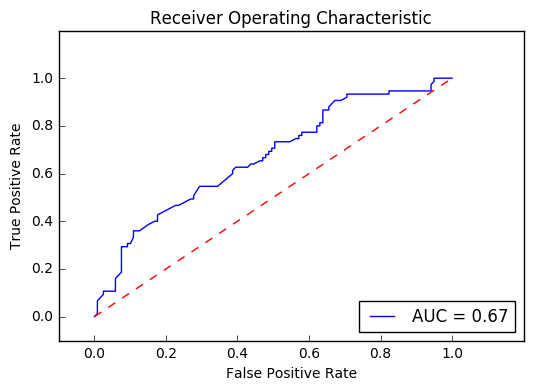

In [38]:
#Predict probabilities of positive class
y_score = clf.predict_proba(X_test)[:,1]

#Calculate false positive rate and true positive rate at different probability thresholds
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_score)

#Calculate the AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

#Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(
    axis='x',          
    top='off')        
plt.tick_params(
    axis='y',          
    right='off')      
plt.show()


Our AUC is 0.67.  Again, while this isn't a super high value, we are at least doing better than random guessing (represented by the red dashed line in the ROC plot.)

Now let's find the most important features of the model, and plot their scores.

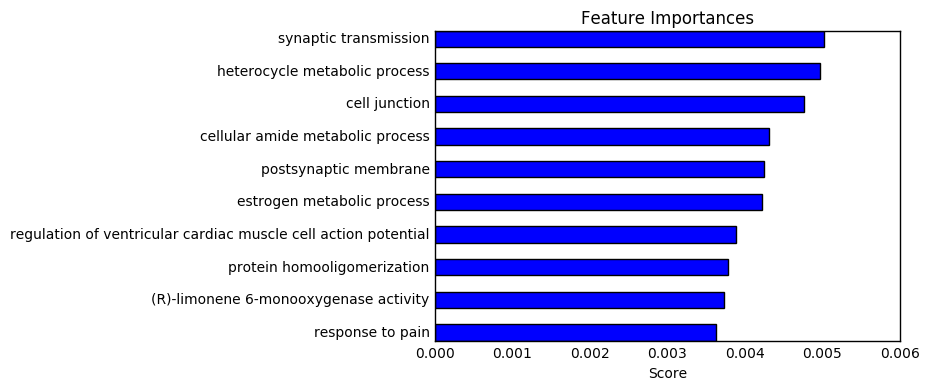

In [39]:
FeatureImportanceList = []

#Extract feature importances
fi = list(zip(X_train, clf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_))
for f in fi:
    index = f[0]
    imp = f[1]
    GOterm = relevantFeatures[int(index)]
    GOterm_imp = (GOterm, imp)
    FeatureImportanceList.append(GOterm_imp)

#Sort features based on score
sortedFeatureImportanceList = sorted(FeatureImportanceList, key=operator.itemgetter(1), reverse = True)

#Examine the top 10 feature importances
GOterms = list(zip(*sortedFeatureImportanceList[:10]))[0]
scores = list(zip(*sortedFeatureImportanceList[:10]))[1]

#Make axes labels evenly space
ind = np.arange(len(GOterms))

#Generate barplot of top 10 feature importances
fig, ax = plt.subplots()
ax.barh(ind,scores,0.5, align='center')
ax.set_yticks(ind)
ax.set_yticklabels(GOterms)
ax.invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Score')
plt.tick_params(
    axis='x',          
    top='off',
    bottom='off')         
plt.tick_params(
    axis='y',        
    left='off',   
    right='off')        
fig.set_facecolor('white')
plt.autoscale()
plt.show()


Some of the features involve neurological processes, including "synaptic transmission" and "postsynaptic membrane".  This is a good sign; while we may not have an extremely accurate model, the fact that some of our most important features for predicting tremors represent brain-related processes makes sense.  We also observe some features that are less expected, such as "estrogen metabolic process" and "(R)-limonene 6-monooxygenase activity".  These could be investiaged further to determine whether they play a role in the underlying biology of tremors.

In conclusion, we generated a Random Forest Classifier model to predict tremors as an ADR, evaluated the model, and examined the most important features of the model in predicting tremors.  The features we used were GO terms based on the targets, enzymes, transporters, and carriers of the drugs.  Though our model is better than random guessing, there is definitely room for improvement.  First, we only had information for about 1000 drugs; we could add additional drugs to our model, for which we have both ADR and feature information.  With more data, our model could potentially build a more accurate classifier.  FAERS (FDA's Adverse Event Reporting System) is an additional ADR database that could be incorporated.  In addition, we could perform feature engineering on the GO term features.  Our model contained nearly 8000 features; it is likely that a good portion of those features have very little relevance for predicting ADRs, and many of them may be correlated with each other as well.  By removing less relevant features, we may increase our ability to accurately predict ADRs.